In [ ]:
!pip install torch torchvision gdown -q

In [1]:
import gdown
import os
from PIL import Image
import gc

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
import torch.nn.functional as F


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import average_precision_score


import random
import warnings
warnings.filterwarnings("ignore")

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything()

### Multi-class probplem

In [14]:
# gdown.download("https://drive.google.com/file/d/1q8Jc3LyQfNxuzAAvIQFAcwrgliHRijix/view?usp=share_link","./class_data.zip", quiet=False, fuzzy=True)
# !unzip -q ./class_data.zip

path_train = './dataset2-master/dataset2-master/images/TRAIN/'
train = pd.DataFrame(columns=['img_id', 'label'])

for label in os.listdir(path_train):
    img_id = os.listdir(path_train + label)

    df = pd.DataFrame(img_id, columns=['img_id'])
    df['img_id'] = os.path.join(path_train, label)+ '/' + df['img_id']
    
    df['label'] = os.listdir(path_train).index(label)
    train = pd.concat([train, df])
        
        
clean_mask = train['img_id'].apply(lambda x: x.split('/')[-1] =='.ipynb_checkpoints')
train = train.loc[~clean_mask, :].reset_index(drop=True)

num_class = train.label.unique()
num_class = len(num_class)
train

path_test = './dataset2-master/dataset2-master/images/TEST/'
test = pd.DataFrame(columns=['img_id', 'label'])

for label in os.listdir(path_test):
    img_id = os.listdir(path_test + label)

    df = pd.DataFrame(img_id, columns=['img_id'])
    df['img_id'] = os.path.join(path_test, label)+ '/' + df['img_id']
    
    df['label'] = os.listdir(path_test).index(label) 
    test = pd.concat([test, df])
    
clean_mask = test['img_id'].apply(lambda x: x.split('/')[-1] =='.ipynb_checkpoints')
test = test.loc[~clean_mask, :].reset_index(drop=True)

test

class ClassDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __getitem__(self, idx):
        path_img = self.data.loc[idx, 'img_id']
        label = self.data.loc[idx, 'label']
        
        img = Image.open(path_img)
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, label
    
    def __len__(self):
        return self.data.shape[0]

BATCH_SIZE=8

transfrom = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

trainset = ClassDataset(train, transfrom)
train_dataloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = ClassDataset(test, transfrom)
test_dataloader = DataLoader(testset, batch_size=1, shuffle=False)

### Utils

def save_model(output_dir, epochs, model, optimizer, criterion):
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, output_dir)

def compute_mAP(pred, multi_class=False):
    
    if multi_class:
        labels, outputs = pred
        y_true = labels.long().cpu().detach().numpy()
        y_pred = outputs.cpu().detach().numpy()
        AP = []
        for i in range(y_true.shape[0]):
            AP.append(average_precision_score(y_true[i], y_pred[i]))
        accuracy = np.mean(AP)
        
    else:
        outputs, labels = pred
        y_true = labels.cpu().detach().numpy()
        y_pred = outputs.cpu().detach().numpy()
        accuracy = accuracy_score(y_true, y_pred)
        
    return accuracy

val(resnet, test_dataloader, criteriation, device)

def val(model, valloader, criteriation, device, multi_label=False):
    model.eval()
    
    val_loss = 0
    val_mAP = 0
    
    true_label = []
    pred_label = []
    
    for batch in valloader:
        img, label = batch
        
        img, label = img.to(device), label.to(device)
        
        with torch.no_grad():
            output = model(img)
            
            if multi_label:
                output = torch.sigmoid(output)
                pred_label.append(output)
                
            else:
                _, preds = torch.max(output, 1)
                pred_label.append(preds.item())
                
            
        loss = criteriation(output, label)
        val_loss += loss.item()
        
        true_label.append(label)
        
        del img, label
        
    if multi_label:
        prediction = (torch.cat(true_label), torch.cat(pred_label))
    else:
        prediction = (torch.tensor(true_label), torch.tensor(pred_label))
        
    val_loss = val_loss / len(testset)
    return val_loss, compute_mAP(prediction, multi_label), prediction
        
        

def training(model, trainloader, valloader, 
             device, epochs, optimizer, criteriation, 
             start=0, path='output/vit.pt', multi_label=False):
    
    metrics = []
    max_val_accuracy = 0
    
    for epoch in range(start, epochs):
        print(f'[{epoch+1}]/[{epochs}] Epoch starts')
        train_loss = 0
        train_acc = 0
        model.train()
        
        for b_ind, batch in enumerate(trainloader):
            
            
            imgs, labels = batch
            imgs, labels = imgs.to(device), labels.to(device)
            
            outputs = model(imgs)
            
            if multi_label:
                outputs = torch.sigmoid(outputs)
                pred = outputs
                train_acc += compute_mAP((labels, pred), multi_label) * labels.size(0)
                
            else:
                pred = torch.max(outputs, 1)[1]
                train_acc +=  float((pred == labels).cpu().numpy().astype(int).sum())
                
                
            Loss = criteriation(outputs, labels)
            train_loss += Loss.item() * labels.size(0)
            
            
            
            if b_ind % 250==0:
                b_loss = Loss.item()
                b_acc = compute_mAP((labels, pred), multi_label)
                print(f'\t Batch train loss: {b_loss}, accuracy {b_acc}')
            
            
            optimizer.zero_grad()
            Loss.backward()
            optimizer.step()
            
            
            del imgs, labels
            
        
        
        val_loss, val_accuracy, _= val(model, valloader, criteriation, device, multi_label)
        train_loss = train_loss / len(trainset)
        train_acc = train_acc / len(trainset)
        
        
        
        print(f'[{epoch+1}]/[{epochs}] End epoch: train loss: {train_loss}, val loss: {val_loss}')
        print(f'\t Epoch train accuracy: {train_acc}, val accuracy: {val_accuracy}\n')
        
        torch.cuda.empty_cache()
        gc.collect()
        
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            save_model(path, epoch, model, optimizer, criteriation)
        
        metrics.append([train_loss, val_loss, train_acc, val_accuracy])
        pd.DataFrame(metrics, columns=['train_loss',
                                       'val_loss', 
                                       'train accuracy',
                                       'val accuracy'
                                      ]).to_csv(path.split('.')[0] + '_metrics.csv', index=False)

### Resnet training

if not os.path.exists('multi_class_output'):
    os.mkdir('multi_class_output')
else:
    print('multi_class_output exists')

!nvidia-smi

import gc

def clean():
    torch.cuda.empty_cache()
    gc.collect()

clean()

In [ ]:
os.environ['CUDA_VISIABLE_DEVICES']='0'

In [ ]:
device = torch.device('cuda')

### Resnet

In [31]:
resnet = torchvision.models.resnet34(pretrained=False, num_classes=4)

resnet = resnet.to(device)

optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-5)
criteriation = nn.CrossEntropyLoss()

training(resnet, train_dataloader, test_dataloader, 
         device, 100, optimizer, criteriation,
         path='multi_class_output/resnet.pt')

### Modified Resnet

In [ ]:
resnet_modified = torchvision.models.resnet34(pretrained=False, num_classes=4)

resnet_modified.conv1 = torch.nn.Conv2d(3, 64, 
                                        kernel_size=(3, 3), 
                                        stride=(1, 1), 
                                        padding=(1, 1), 
                                        bias=False)

resnet_modified.maxpool = torch.nn.Identity()

resnet_modified = resnet_modified.to(device)

optimizer = torch.optim.Adam(resnet_modified.parameters(), lr=1e-5)
criteriation = nn.CrossEntropyLoss()

training(resnet_modified, train_dataloader, test_dataloader, 
         device, 10, optimizer, criteriation
         path='multi_class_output/resnet_modified.pt')

### EfficiencyNet

In [ ]:
effnet = torchvision.models.efficientnet_b0(pretrained=False, num_classes=4)

effnet = effnet.to(device)

optimizer = torch.optim.Adam(effnet.parameters(), lr=1e-5)
criteriation = nn.CrossEntropyLoss()

training(effnet, train_dataloader, test_dataloader, 
         device, 10, optimizer, criteriation,
         path='multi_class_output/effnet.pt')

### VIT

In [6]:
from transformer.vit import Transformer

BATCH_SIZE=4

transfrom = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

trainset = ClassDataset(train, transfrom)
train_dataloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = ClassDataset(test, transfrom)
test_dataloader = DataLoader(testset, batch_size=1, shuffle=False)

In [ ]:
transformer = Transformer(img_size=(240, 320),
                          patch_size=(8, 8),
                          in_channels=3,
                          n_classes=num_class,
                          embed_dim=128,
                          depth=6,
                          n_heads=16,
                          mlp_ratio=4.,
                          qkv_bias=True,
                          p=0.3,
                          attn_p=0.3
                         )

transformer = transformer.to(device)

optimizer = torch.optim.Adam(transformer.parameters(), lr=1e-5)
criteriation = nn.CrossEntropyLoss()

training(transformer, train_dataloader, test_dataloader, 
         device, 10, optimizer,
         path='multi_class_output/transformer.pt')

In [87]:
resnet.load_state_dict(torch.load(f'multi_class_output/resnet.pt')['model_state_dict'])
resnet = resnet.to(device)

resnet_modified.load_state_dict(torch.load(f'multi_class_output/resnet_modified.pt')['model_state_dict'])
resnet_modified = resnet_modified.to(device)

effnet.load_state_dict(torch.load(f'multi_class_output/effnet.pt')['model_state_dict'])
effnet = effnet.to(device)

transformer.load_state_dict(torch.load(f'multi_class_output/transformer.pt')['model_state_dict'])
transformer = transformer.to(device)

### Number of parameters in model

In [ ]:
def count_params(model):
    return sum(p.numel() for p in model.parameters())

In [50]:
models = [resnet, resnet_modified, effnet, transformer]
models_name = ['resnet: ', 'resnet_modified: ', 'effnet: ', 'transformer: ']


for name, check_model in zip(models_name, models):
    print(name, count_params(check_model) / 1000)

resnet:  21286.724
resnet_modified:  21286.724
effnet:  4012.672
transformer:  1368.964


### Metrics

In [54]:
metrics = [met for met in os.listdir('multi_class_output') if met[-3:]=='csv']

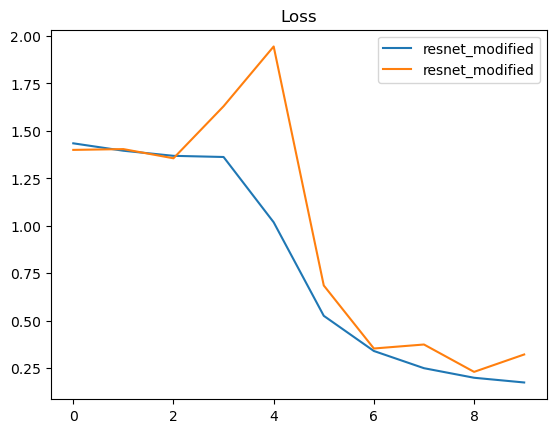

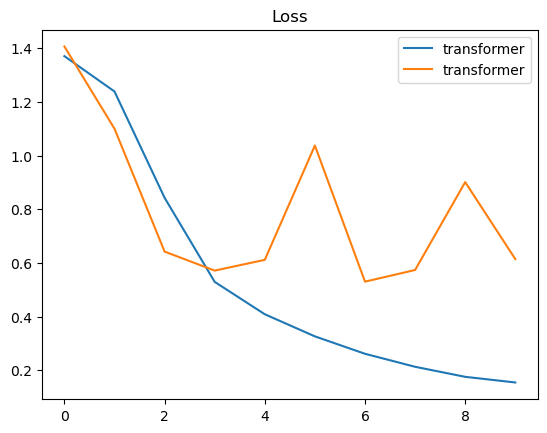

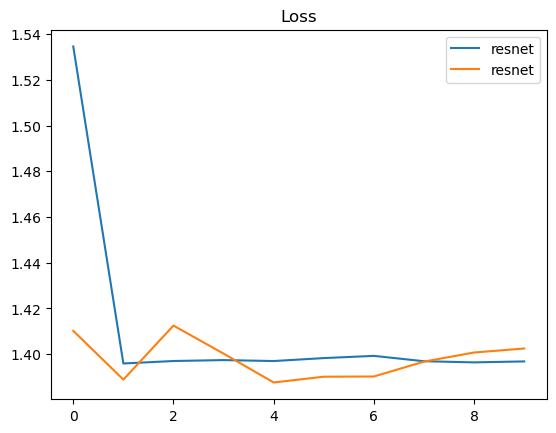

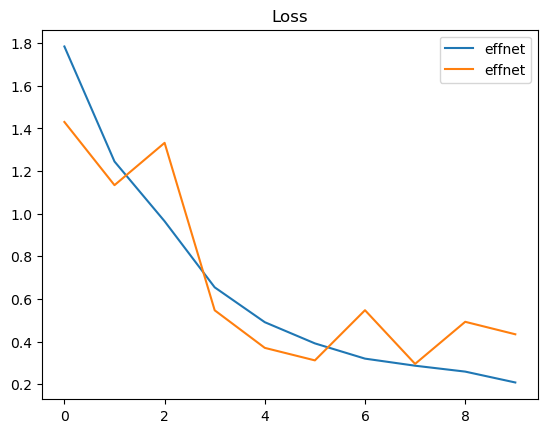

In [63]:
for metric_file_name in metrics:
    
    path_metric = os.path.join('multi_class_output', metric_file_name)
    metric_file = pd.read_csv(path_metric)
    
    train_loss = metric_file['train_loss']
    val_loss = metric_file['val_loss']
    plt.plot(np.arange(len(train_loss)), train_loss, label=metric_file_name[:-12])
    plt.plot(np.arange(len(val_loss)), val_loss, label=metric_file_name[:-12])
    plt.legend()
    plt.title('Loss')
    plt.show()

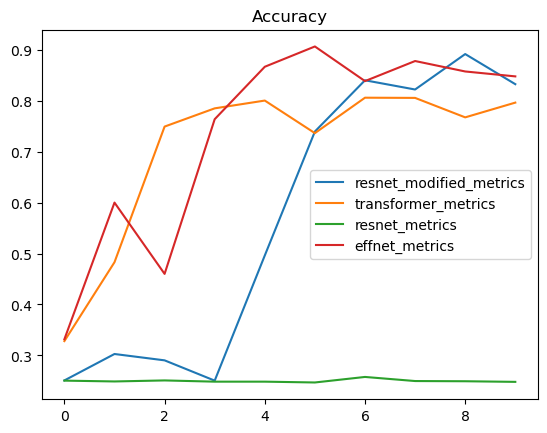

In [61]:
for metric_file_name in metrics:
    
    path_metric = os.path.join('multi_class_output', metric_file_name)
    metric_file = pd.read_csv(path_metric)
    
    val_accuracy = metric_file['val accuracy']
    plt.plot(np.arange(len(val_accuracy)), val_accuracy, label=metric_file_name[:-4])
    plt.legend()
    plt.title('Accuracy')

In [7]:
from trainer import Trainer
from data.multi_label_build_data import build_dataloader


train_dataloader, test_dataloader, num_train, num_test, NUM_CLASS = build_dataloader(transfrom, BATCH_SIZE)
criteriation=nn.CrossEntriopyLoss()

In [92]:
def eval_metrics(models, names, multi_label=False):
    
    models_metrics=[]
    
    for name, model in zip(names, models):
        _, _, preds = Trainer(model, device, criteriation 
                              train_dataloader, test_dataloader, 
                              num_train, num_test, multi_label).val()
        
        if not multi_label:

            accuracy = sklearn.metrics.accuracy_score(*preds)
            precis_macro = sklearn.metrics.precision_score(*preds, average='macro')
            precis_micro = sklearn.metrics.precision_score(*preds, average='micro')

            recall_macro = sklearn.metrics.recall_score(*preds, average='macro')
            recall_micro = sklearn.metrics.recall_score(*preds, average='micro')

            f1_macro = sklearn.metrics.f1_score(*preds, average='macro')
            f1_micro = sklearn.metrics.f1_score(*preds, average='micro')

            models_metrics.append([name, accuracy, 
                                   precis_macro, precis_micro, 
                                   recall_macro, recall_micro,
                                   f1_macro, f1_micro
                                  ])
            columns=['model', 'accuracy', 'precision (macro)', 'precision (micro)', 
                     'recall (macro)', 'recall (micro)', 'F1 (macro)', 'F1 (micro)']
            
            
        else:
            ex_r = sklearn.metrics.accuracy_score(*preds, normalize=True, sample_weight=None)
            hamm = sklearn.metrics.accuracy_score(*preds, normalize=True, sample_weight=None)
            Recall = sklearn.metrics.precision_score(*preds, y_pred=y_pred, average='samples') 
            Precision = sklearn.metrics.recall_score(*preds, average='samples')
            f1 = sklearn.metrics.f1_score(*preds, average='samples')
            models_metrics.append([name, ex_r, 
                                   hamm, Recall, 
                                   Precision, f1,
                                  ])
            
            columns=['model', 'Exact Match Ratio', 'Hamming loss', 'Recall', 'Precision', 'F1']


            

    models_metrics = pd.DataFrame(models_metrics, columns=columns)                                                          ])
    return models_metrics
    
    

In [89]:
models = [resnet, resnet_modified, effnet, transformer]
models_name = ['resnet', 'resnet_modified', 'effnet', 'transformer']

In [93]:
eval_metrics(models, models_name, test_dataloader, device)

,model,accuracy,precision (macro),precision (micro),recall (macro),recall (micro),F1 (macro),F1 (micro)
0,resnet,0.257740,0.139652,0.257740,0.257164,0.257740,0.147490,0.257740
1,resnet_modified,0.891435,0.902690,0.891435,0.891526,0.891435,0.893276,0.891435
2,effnet,0.906313,0.906600,0.906313,0.906562,0.906313,0.905018,0.906313
3,transformer,0.805790,0.810547,0.805790,0.805905,0.805790,0.806751,0.805790


### Multi-label problem

import pandas as pd

In [4]:
# gdown.download("https://drive.google.com/file/d/15aX9gKeSlGoUJBHAQGqkL5euq0kDKkwg/view?usp=share_link","./label_data.zip", quiet=False, fuzzy=True)
# !unzip -q ./label_data.zip

Downloading...
From (uriginal): https://drive.google.com/uc?id=15aX9gKeSlGoUJBHAQGqkL5euq0kDKkwg
From (redirected): https://drive.google.com/uc?id=15aX9gKeSlGoUJBHAQGqkL5euq0kDKkwg&confirm=t&uuid=95ea0f1c-7047-40b0-928f-b51b4caa8e91
To: /home/jovyan/work/label_data.zip
100%|██████████████████████████████████████████████████████████████████████████████| 4.51G/4.51G [01:58<00:00, 38.1MB/s]


data = pd.read_csv('sample_labels.csv')

data['lables'] = data['Finding Labels'].str.split('|')

labels = []
for lable in data['lables'].values:
    labels.extend(lable)   
    
labels = pd.DataFrame(labels, columns=['labels'])

labels['labels'].hist(figsize=(20, 10))
labels.value_counts()

data['Image Index'] = './sample/images/' + data['Image Index']

chen = []
for path_img in data['Image Index'].values:
    img = Image.open(path_img)
    chen.append(transforms.ToTensor()(img).shape)

bad_img = data.loc[pd.DataFrame(chen)[0] > 1, 'Image Index'].values

for path_img in bad_img:
    img = plt.imread(path_img)
    img = img[:, :, 0]
    img = Image.fromarray(np.uint8(img * 255), 'L')
    img.save(path_img,"PNG")


### Utils

if not os.path.exists('multi_label_output'):
    os.mkdir('multi_label_output')
else:
    print('multi_label_output exists')

class MultiDataset(Dataset):
    def __init__(self, data, transform=None, bad_img=[]):
        self.data = data
        self.transform = transform
        self.labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
                        'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
                        'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
                        'Pneumothorax']
        
        self.bad_img = bad_img
        
    def __getitem__(self, idx):
        path_img = self.data.loc[idx, 'Image Index']
        
        label = self.data.loc[idx, 'lables']
        label = [self.labels.index(_) for _ in label]
        labels = np.zeros(len(self.labels))
        labels[label] = 1
        labels = torch.tensor(labels)
        
        
        img = Image.open(path_img)
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, labels.squeeze(0).float()
    
    def __len__(self):
        return self.data.shape[0]

# change
train = data.loc[:int(0.8*data.shape[0]), :]
test = data.loc[int(0.8*data.shape[0])+1:, :].reset_index(drop=True)

labels = []
for lable in train['lables'].values:
    labels.extend(lable)   
    
labels = pd.DataFrame(labels, columns=['labels'])

labels['labels'].hist(figsize=(20, 10), bins=15)
labels.value_counts()

testlabels['labels'].hist(figsize=(20, 10), bins=15)


testlabels = []
for lable in test['lables'].values:
    testlabels.extend(lable)   
    
testlabels = pd.DataFrame(testlabels, columns=['labels'])

testlabels['labels'].hist(figsize=(20, 10))
testlabels.value_counts()

BATCH_SIZE=8

transfrom = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

trainset = MultiDataset(train, transfrom)
train_dataloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = MultiDataset(test, transfrom)
test_dataloader = DataLoader(testset, batch_size=1, shuffle=False)

i=0
for (img, lab) in train_dataloader:
    print(img.shape)
    plt.imshow(img[0].permute(1, 2, 0))
    plt.title(str(lab))
    plt.show()
    
    if i > 3:
        break
    i+=1
    

num_class = len(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
                        'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
                        'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
                        'Pneumothorax'])

!nvidia-smi

os.environ['CUDA_VISIABLE_DEVICES'] = '0'

device = torch.device('cuda')

### Losses

criteriation = nn.BCELoss()

import torch.nn.functional as F
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = F.cross_entropy(inputs, targets)
        loss = self.alpha * (1 - torch.exp(-bce_loss)) ** self.gamma * bce_loss
        return loss

criteriation = FocalLoss()

### Resnet

In [79]:
resnet = torchvision.models.resnet34(pretrained=False, num_classes=num_class)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [80]:
resnet = resnet.to(device)

In [81]:
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-5)

In [82]:
training(resnet, train_dataloader, test_dataloader, 
         device, 10, optimizer,
         path='multi_label_output/resnet.pt',
         multi_label=True
        )

[1]/[10] Epoch starts
	 Batch train loss: 2.7625088691711426, accuracy 0.17936646686646684
	 Batch train loss: 2.191222667694092, accuracy 0.80625
	 Batch train loss: 3.8024790287017822, accuracy 0.7285183566433566
[1]/[10] End epoch: train loss: 2.725007418087095, val loss: 2.6042918208238803
	 Epoch train accuracy: 0.6429346674321593, val accuracy: 0.6819039915382467

[2]/[10] Epoch starts
	 Batch train loss: 2.3805997371673584, accuracy 0.5551136363636363
	 Batch train loss: 4.2320451736450195, accuracy 0.6959945436507936
	 Batch train loss: 3.271646499633789, accuracy 0.850761217948718
[2]/[10] End epoch: train loss: 2.575718930174276, val loss: 2.572468086930921
	 Epoch train accuracy: 0.6892495620218593, val accuracy: 0.6438088423536683

[3]/[10] Epoch starts
	 Batch train loss: 2.1712095737457275, accuracy 0.7457386363636364
	 Batch train loss: 3.5367469787597656, accuracy 0.6618303571428572
	 Batch train loss: 3.7863380908966064, accuracy 0.48470256595256594
[3]/[10] End epoch:

### ResNet modified

In [83]:
resnet_modified = torchvision.models.resnet34(pretrained=False, num_classes=num_class)

In [84]:
resnet_modified.conv1 = torch.nn.Conv2d(1, 64, 
                                        kernel_size=(3, 3), 
                                        stride=(1, 1), 
                                        padding=(1, 1), 
                                        bias=False)

resnet_modified.maxpool = torch.nn.Identity()
resnet_modified = resnet_modified.to(device)

In [85]:
optimizer = torch.optim.Adam(resnet_modified.parameters(), lr=1e-5)

In [86]:
training(resnet_modified, train_dataloader, test_dataloader, 
         device, 10, optimizer,
         path='multi_label_output/resnet_modified.pt',
         multi_label=True
        )

[1]/[10] Epoch starts
	 Batch train loss: 2.3593122959136963, accuracy 0.18511904761904763
	 Batch train loss: 3.9634599685668945, accuracy 0.5624350649350649
	 Batch train loss: 2.4152369499206543, accuracy 0.775
[1]/[10] End epoch: train loss: 2.6619902515624014, val loss: 2.584131169276616
	 Epoch train accuracy: 0.6670181112779856, val accuracy: 0.6823532155557133

[2]/[10] Epoch starts
	 Batch train loss: 2.712862968444824, accuracy 0.5604166666666666
	 Batch train loss: 3.8412115573883057, accuracy 0.5768353174603174
	 Batch train loss: 2.5749313831329346, accuracy 0.49434523809523806
[2]/[10] End epoch: train loss: 2.5607445260752804, val loss: 2.55565728501057
	 Epoch train accuracy: 0.6912752752503107, val accuracy: 0.6834964947910979

[3]/[10] Epoch starts
	 Batch train loss: 2.8372914791107178, accuracy 0.570486111111111
	 Batch train loss: 5.342743396759033, accuracy 0.672871027781742
	 Batch train loss: 2.1118133068084717, accuracy 0.84375
[3]/[10] End epoch: train loss: 2

### EfficiencyNet

In [87]:
effnet = torchvision.models.efficientnet_b0(pretrained=False, num_classes=num_class)
effnet.features[0][0] = nn.Conv2d(1, 32, 
                                  kernel_size=(3, 3), 
                                  stride=(2, 2), 
                                  padding=(1, 1), 
                                  bias=False)
effnet = effnet.to(device)

In [88]:
optimizer = torch.optim.Adam(effnet.parameters(), lr=1e-5)

In [89]:
training(effnet, train_dataloader, test_dataloader, 
         device, 10, optimizer,
         path='multi_label_output/effnet.pt',
         multi_label=True
        )

[1]/[10] Epoch starts
	 Batch train loss: 3.2131295204162598, accuracy 0.227918956043956
	 Batch train loss: 4.843538284301758, accuracy 0.37846771284271286
	 Batch train loss: 3.4795894622802734, accuracy 0.2202876984126984
[1]/[10] End epoch: train loss: 2.9584787274682802, val loss: 2.7612576998311638
	 Epoch train accuracy: 0.40561113193136583, val accuracy: 0.623866187955171

[2]/[10] Epoch starts
	 Batch train loss: 2.913959264755249, accuracy 0.4612689393939394
	 Batch train loss: 3.279076099395752, accuracy 0.4264430014430014
	 Batch train loss: 2.899070978164673, accuracy 0.6256944444444446
[2]/[10] End epoch: train loss: 2.7988112973263166, val loss: 2.6640624388533976
	 Epoch train accuracy: 0.5249383559348526, val accuracy: 0.6541935695057908

[3]/[10] Epoch starts
	 Batch train loss: 2.4292287826538086, accuracy 0.40812728937728937
	 Batch train loss: 3.187927722930908, accuracy 0.680952380952381
	 Batch train loss: 2.4603471755981445, accuracy 0.5129960317460318
[3]/[10] 

### Trnasformer

In [108]:
BATCH_SIZE=4

transfrom = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

trainset = MultiDataset(train, transfrom)
train_dataloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = MultiDataset(test, transfrom)
test_dataloader = DataLoader(testset, batch_size=1, shuffle=False)

In [109]:
from vit import Transformer

In [111]:
transformer = Transformer(img_size=(256, 256),
                          patch_size=(8, 8),
                          in_channels=1,
                          n_classes=num_class,
                          embed_dim=128,
                          depth=6,
                          n_heads=16,
                          mlp_ratio=4.,
                          qkv_bias=True,
                          p=0.3,
                          attn_p=0.3
                         )

In [112]:
transformer = transformer.to(device)

In [113]:
optimizer = torch.optim.Adam(transformer.parameters(), lr=1e-5)

In [114]:
training(transformer, train_dataloader, test_dataloader, 
         device, 20, optimizer,
         path='multi_label_output/transformer.pt',
         multi_label=True
        )

[1]/[20] Epoch starts


OutOfMemoryError: CUDA out of memory. Tried to allocate 226.00 MiB (GPU 0; 23.69 GiB total capacity; 21.34 GiB already allocated; 139.81 MiB free; 21.53 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF